## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [2]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_paca_pruned.pth
pquant
data
smartpixels


In [3]:
model = torchvision.models.resnet18()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = model.to(device)

model

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Add pruning and quantization
Begin prunning with MDMM pruning with Unstructured Sparsity metric function

In [4]:
from pquant import get_default_config
from IPython.display import JSON

pruning_method = "mdmm"
config = get_default_config(pruning_method)
JSON(config)

<IPython.core.display.JSON object>

In [5]:
# Replace layers with compressed layers
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model = add_compression_layers(model, config, input_shape)
model

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_1, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_2, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_3, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

In [6]:
import torchvision.transforms as transforms
from pquant import get_layer_keep_ratio, get_model_losses
from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
from tqdm import tqdm


def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")

def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖ Epoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
        
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    """
    Validation with progress bar and accuracy summary.
    """
    model.eval()
    correct = total = 0


    with torch.no_grad():
        with tqdm(testloader,
                  desc=f"Val   ‖ Epoch {epoch}",
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                running_acc = 100. * correct / total
                pbar.set_postfix(acc=f"{running_acc:.2f}%")

    ratio = get_layer_keep_ratio(model)
    print(f"Accuracy: {correct/total*100:.2f}% | Remaining weights: {ratio*100:.2f}% \n")



BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

In [8]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model = iterative_train(model = model, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )

Train ‖ Epoch 0: 100%|██████████| 196/196 [00:07<00:00, 25.49batch/s, loss=12.4680]


Loss=1.5851 | Reg=10.8829


Val   ‖ Epoch 0: 100%|██████████| 196/196 [00:05<00:00, 38.22batch/s, acc=48.26%]


Accuracy: 48.26% | Remaining weights: 96.49% 



Train ‖ Epoch 1: 100%|██████████| 196/196 [00:07<00:00, 25.62batch/s, loss=23.3944]


Loss=1.4407 | Reg=21.9537


Val   ‖ Epoch 1: 100%|██████████| 196/196 [00:04<00:00, 39.47batch/s, acc=48.05%]


Accuracy: 48.05% | Remaining weights: 95.73% 



Train ‖ Epoch 2: 100%|██████████| 196/196 [00:07<00:00, 25.69batch/s, loss=24.0259]


Loss=1.2038 | Reg=22.8221


Val   ‖ Epoch 2: 100%|██████████| 196/196 [00:04<00:00, 39.53batch/s, acc=58.24%]


Accuracy: 58.24% | Remaining weights: 94.28% 



Train ‖ Epoch 3: 100%|██████████| 196/196 [00:07<00:00, 25.48batch/s, loss=25.6517]


Loss=1.4249 | Reg=24.2268


Val   ‖ Epoch 3: 100%|██████████| 196/196 [00:04<00:00, 39.57batch/s, acc=49.98%]


Accuracy: 49.98% | Remaining weights: 93.06% 



Train ‖ Epoch 4: 100%|██████████| 196/196 [00:07<00:00, 25.66batch/s, loss=21.7085]


Loss=1.1868 | Reg=20.5217


Val   ‖ Epoch 4: 100%|██████████| 196/196 [00:04<00:00, 39.80batch/s, acc=61.27%]


Accuracy: 61.27% | Remaining weights: 90.58% 



Train ‖ Epoch 5: 100%|██████████| 196/196 [00:07<00:00, 25.48batch/s, loss=23.1276]


Loss=1.5271 | Reg=21.6005


Val   ‖ Epoch 5: 100%|██████████| 196/196 [00:04<00:00, 39.28batch/s, acc=45.62%]


Accuracy: 45.62% | Remaining weights: 89.36% 



Train ‖ Epoch 6: 100%|██████████| 196/196 [00:07<00:00, 25.41batch/s, loss=18.9578]


Loss=1.0937 | Reg=17.8641


Val   ‖ Epoch 6: 100%|██████████| 196/196 [00:04<00:00, 39.93batch/s, acc=63.49%]


Accuracy: 63.49% | Remaining weights: 86.23% 



Train ‖ Epoch 7: 100%|██████████| 196/196 [00:07<00:00, 25.84batch/s, loss=20.4797]


Loss=1.4207 | Reg=19.0590


Val   ‖ Epoch 7: 100%|██████████| 196/196 [00:04<00:00, 39.53batch/s, acc=41.14%]


Accuracy: 41.14% | Remaining weights: 85.27% 



Train ‖ Epoch 8: 100%|██████████| 196/196 [00:07<00:00, 25.42batch/s, loss=16.6170]


Loss=0.9998 | Reg=15.6173


Val   ‖ Epoch 8: 100%|██████████| 196/196 [00:04<00:00, 40.15batch/s, acc=63.87%]


Accuracy: 63.87% | Remaining weights: 81.55% 



Train ‖ Epoch 9: 100%|██████████| 196/196 [00:07<00:00, 25.40batch/s, loss=18.0202]


Loss=1.3470 | Reg=16.6733


Val   ‖ Epoch 9: 100%|██████████| 196/196 [00:04<00:00, 40.06batch/s, acc=50.33%]


Accuracy: 50.33% | Remaining weights: 80.76% 



Train ‖ Epoch 10: 100%|██████████| 196/196 [00:07<00:00, 25.96batch/s, loss=14.7295]


Loss=1.0390 | Reg=13.6906


Val   ‖ Epoch 10: 100%|██████████| 196/196 [00:04<00:00, 39.67batch/s, acc=63.10%]


Accuracy: 63.10% | Remaining weights: 76.63% 



Train ‖ Epoch 11: 100%|██████████| 196/196 [00:07<00:00, 25.28batch/s, loss=15.9297]


Loss=1.2916 | Reg=14.6381


Val   ‖ Epoch 11: 100%|██████████| 196/196 [00:04<00:00, 39.29batch/s, acc=51.38%]


Accuracy: 51.38% | Remaining weights: 76.01% 



Train ‖ Epoch 12: 100%|██████████| 196/196 [00:07<00:00, 25.53batch/s, loss=13.1309]


Loss=1.1050 | Reg=12.0259


Val   ‖ Epoch 12: 100%|██████████| 196/196 [00:04<00:00, 40.02batch/s, acc=64.22%]


Accuracy: 64.22% | Remaining weights: 71.71% 



Train ‖ Epoch 13: 100%|██████████| 196/196 [00:07<00:00, 25.59batch/s, loss=14.0188]


Loss=1.2279 | Reg=12.7909


Val   ‖ Epoch 13: 100%|██████████| 196/196 [00:04<00:00, 39.72batch/s, acc=43.69%]


Accuracy: 43.69% | Remaining weights: 71.18% 



Train ‖ Epoch 14: 100%|██████████| 196/196 [00:07<00:00, 25.78batch/s, loss=11.5684]


Loss=0.9515 | Reg=10.6169


Val   ‖ Epoch 14: 100%|██████████| 196/196 [00:05<00:00, 39.12batch/s, acc=64.80%]


Accuracy: 64.80% | Remaining weights: 66.93% 



Train ‖ Epoch 15: 100%|██████████| 196/196 [00:07<00:00, 25.69batch/s, loss=12.2271]


Loss=1.0986 | Reg=11.1284


Val   ‖ Epoch 15: 100%|██████████| 196/196 [00:04<00:00, 39.60batch/s, acc=46.16%]


Accuracy: 46.16% | Remaining weights: 66.37% 



Train ‖ Epoch 16: 100%|██████████| 196/196 [00:07<00:00, 25.73batch/s, loss=10.3543]


Loss=1.0380 | Reg=9.3163


Val   ‖ Epoch 16: 100%|██████████| 196/196 [00:05<00:00, 39.16batch/s, acc=62.02%]


Accuracy: 62.02% | Remaining weights: 62.30% 



Train ‖ Epoch 17: 100%|██████████| 196/196 [00:07<00:00, 25.99batch/s, loss=11.2816]


Loss=1.6042 | Reg=9.6774


Val   ‖ Epoch 17: 100%|██████████| 196/196 [00:04<00:00, 39.79batch/s, acc=49.13%]


Accuracy: 49.13% | Remaining weights: 61.75% 



Train ‖ Epoch 18: 100%|██████████| 196/196 [00:07<00:00, 26.21batch/s, loss=9.4910] 


Loss=1.2874 | Reg=8.2036


Val   ‖ Epoch 18: 100%|██████████| 196/196 [00:04<00:00, 39.50batch/s, acc=59.06%]


Accuracy: 59.06% | Remaining weights: 57.91% 



Train ‖ Epoch 19: 100%|██████████| 196/196 [00:07<00:00, 25.97batch/s, loss=9.4670]


Loss=1.1586 | Reg=8.3085


Val   ‖ Epoch 19: 100%|██████████| 196/196 [00:04<00:00, 39.48batch/s, acc=53.55%]


Accuracy: 53.55% | Remaining weights: 57.16% 



Train ‖ Epoch 20: 100%|██████████| 196/196 [00:07<00:00, 26.13batch/s, loss=8.4565]


Loss=1.1622 | Reg=7.2943


Val   ‖ Epoch 20: 100%|██████████| 196/196 [00:04<00:00, 39.81batch/s, acc=54.73%]


Accuracy: 54.73% | Remaining weights: 53.88% 



Train ‖ Epoch 21: 100%|██████████| 196/196 [00:07<00:00, 26.50batch/s, loss=8.1606]


Loss=0.9888 | Reg=7.1718


Val   ‖ Epoch 21: 100%|██████████| 196/196 [00:04<00:00, 39.81batch/s, acc=53.88%]


Accuracy: 53.88% | Remaining weights: 52.88% 



Train ‖ Epoch 22: 100%|██████████| 196/196 [00:07<00:00, 26.39batch/s, loss=7.7852]


Loss=1.3460 | Reg=6.4392


Val   ‖ Epoch 22: 100%|██████████| 196/196 [00:04<00:00, 39.81batch/s, acc=62.10%]


Accuracy: 62.10% | Remaining weights: 50.09% 



Train ‖ Epoch 23: 100%|██████████| 196/196 [00:07<00:00, 25.99batch/s, loss=7.1201]


Loss=0.9079 | Reg=6.2122


Val   ‖ Epoch 23: 100%|██████████| 196/196 [00:04<00:00, 39.21batch/s, acc=54.83%]


Accuracy: 54.83% | Remaining weights: 48.92% 



Train ‖ Epoch 24: 100%|██████████| 196/196 [00:07<00:00, 26.68batch/s, loss=6.7830]


Loss=1.0496 | Reg=5.7334


Val   ‖ Epoch 24: 100%|██████████| 196/196 [00:04<00:00, 39.67batch/s, acc=58.82%]


Accuracy: 58.82% | Remaining weights: 46.72% 



Train ‖ Epoch 25: 100%|██████████| 196/196 [00:03<00:00, 55.10batch/s, loss=0.8846]


Loss=0.8846 | Reg=0.0000


Val   ‖ Epoch 25: 100%|██████████| 196/196 [00:02<00:00, 83.60batch/s, acc=68.41%]


Accuracy: 68.41% | Remaining weights: 45.42% 



Train ‖ Epoch 26: 100%|██████████| 196/196 [00:03<00:00, 54.81batch/s, loss=0.7874]


Loss=0.7874 | Reg=0.0000


Val   ‖ Epoch 26: 100%|██████████| 196/196 [00:02<00:00, 83.57batch/s, acc=71.32%]


Accuracy: 71.32% | Remaining weights: 43.86% 



Train ‖ Epoch 27: 100%|██████████| 196/196 [00:03<00:00, 53.98batch/s, loss=0.4903]


Loss=0.4903 | Reg=0.0000


Val   ‖ Epoch 27: 100%|██████████| 196/196 [00:02<00:00, 82.32batch/s, acc=75.17%]


Accuracy: 75.17% | Remaining weights: 43.78% 



Train ‖ Epoch 28: 100%|██████████| 196/196 [00:03<00:00, 54.34batch/s, loss=0.8084]


Loss=0.8084 | Reg=0.0000


Val   ‖ Epoch 28: 100%|██████████| 196/196 [00:02<00:00, 80.99batch/s, acc=75.10%]


Accuracy: 75.10% | Remaining weights: 43.36% 



Train ‖ Epoch 29: 100%|██████████| 196/196 [00:03<00:00, 53.93batch/s, loss=0.6990]


Loss=0.6990 | Reg=0.0000


Val   ‖ Epoch 29: 100%|██████████| 196/196 [00:02<00:00, 81.28batch/s, acc=78.09%]


Accuracy: 78.09% | Remaining weights: 43.32% 



Train ‖ Epoch 30: 100%|██████████| 196/196 [00:03<00:00, 54.67batch/s, loss=0.5345]


Loss=0.5345 | Reg=0.0000


Val   ‖ Epoch 30: 100%|██████████| 196/196 [00:02<00:00, 82.94batch/s, acc=75.32%]


Accuracy: 75.32% | Remaining weights: 43.05% 



Train ‖ Epoch 31: 100%|██████████| 196/196 [00:03<00:00, 53.39batch/s, loss=0.7983]


Loss=0.7983 | Reg=0.0000


Val   ‖ Epoch 31: 100%|██████████| 196/196 [00:02<00:00, 83.63batch/s, acc=79.57%]


Accuracy: 79.57% | Remaining weights: 43.02% 



Train ‖ Epoch 32: 100%|██████████| 196/196 [00:03<00:00, 54.73batch/s, loss=0.9840]


Loss=0.9840 | Reg=0.0000


Val   ‖ Epoch 32: 100%|██████████| 196/196 [00:02<00:00, 83.98batch/s, acc=76.66%]


Accuracy: 76.66% | Remaining weights: 42.82% 



Train ‖ Epoch 33: 100%|██████████| 196/196 [00:03<00:00, 53.87batch/s, loss=0.7089]


Loss=0.7089 | Reg=0.0000


Val   ‖ Epoch 33: 100%|██████████| 196/196 [00:02<00:00, 82.54batch/s, acc=80.80%]


Accuracy: 80.80% | Remaining weights: 42.79% 



Train ‖ Epoch 34: 100%|██████████| 196/196 [00:03<00:00, 55.02batch/s, loss=1.0415]


Loss=1.0415 | Reg=0.0000


Val   ‖ Epoch 34: 100%|██████████| 196/196 [00:02<00:00, 83.37batch/s, acc=78.30%]

Accuracy: 78.30% | Remaining weights: 42.63% 



/tmp/ipykernel_409179/1596906618.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


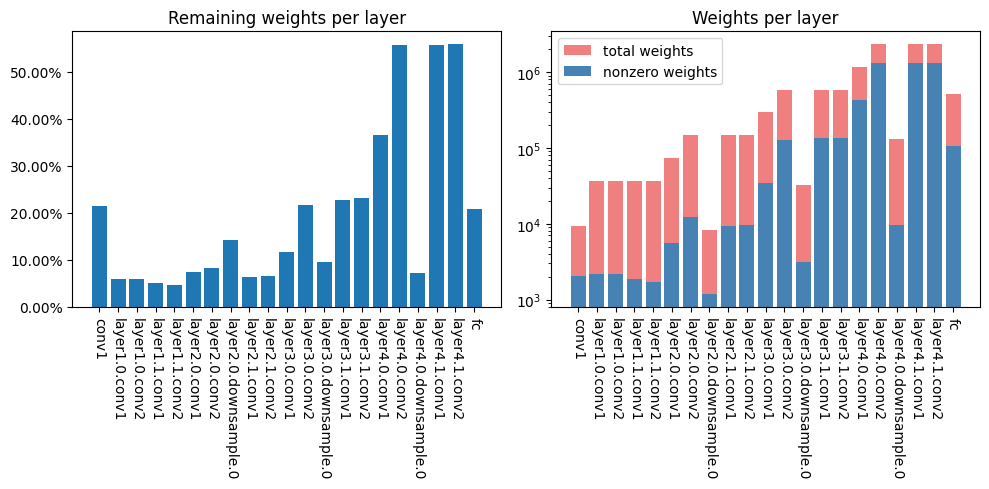

In [9]:
import numpy as np
from pquant import remove_pruning_from_model
import matplotlib.pyplot as plt
# Remove compression layers, leaves Quantized activations in place
model = remove_pruning_from_model(trained_model, config)

# Plot remaining weights
names = []
remaining = []
total_w = []
nonzeros = []
for n, m in trained_model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [10]:
def extract_conv_patterns(model):
    """
    Extracts unique binary patterns and their counts from convolutional layers
    of a given model in a backend-agnostic way.

    Args:
        model: A Keras or PyTorch model.

    Returns:
        A dictionary where keys are the names of convolutional layers and
        values are another dictionary containing:
        - 'patterns': A NumPy array of the unique binary patterns.
        - 'counts': A NumPy array with the count for each unique pattern.
        - 'kernel_shape': The original (height, width) of the kernel.
    """
    patterns_by_layer = {}
    backend = keras.backend.backend()

    # Iterate through model layers/modules
    if backend == "torch":
        modules = model.named_modules()
    else: # TensorFlow
        modules = [(layer.name, layer) for layer in model.layers]

    for name, module in modules:
        is_conv_layer = False
        if backend == "torch" and isinstance(module, (keras.layers.Conv2D, torch.nn.Conv2d)):
            weight = module.weight.detach()
            is_conv_layer = len(weight.shape) == 4
        elif backend == "tensorflow" and isinstance(module, keras.layers.Conv2D):
            weight = module.kernel
            is_conv_layer = True

        if is_conv_layer:
            all_patterns_flat = keras.ops.reshape(weight, (weight.shape[0], -1))
            all_patterns_binary = keras.ops.cast(all_patterns_flat > 0, dtype="float32")

            num_bits = all_patterns_binary.shape[1]
            if num_bits == 0:
                continue

            powers_of_2 = keras.ops.power(2.0, keras.ops.arange(num_bits, dtype="float32"))
            hashes = keras.ops.sum(all_patterns_binary * powers_of_2, axis=1)

            unique_hashes, counts = np.unique(keras.ops.convert_to_numpy(hashes), return_counts=True)
            unique_patterns_binary = ((unique_hashes[:, None] & (1 << np.arange(num_bits))) > 0).astype(float)
            
            sort_indices = np.argsort(counts)[::-1]
            patterns_by_layer[name] = {
                'patterns': unique_patterns_binary[sort_indices],
                'counts': counts[sort_indices],
                'kernel_shape': (weight.shape[2], weight.shape[3])
            }
            print(f"Processed layer '{name}', found {len(counts)} unique patterns.")

    return patterns_by_layer

In [ ]:
import math

def visualize_conv_patterns(model, layer_name, max_patterns_to_show=16):
    """
    Visualizes the dominant binary patterns for a specific convolutional layer.
    """
    target_module = None
    for name, module in model.named_modules():
        if name == layer_name and hasattr(module, "pruning_layer"):
            pruning_layer = module.pruning_layer
            if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                target_module = module
                break
    
    if target_module is None:
        print(f"Error: Could not find a PACA-pruned layer named '{layer_name}'.")
        return
        
    metric_fn = target_module.pruning_layer.metric_fn
    # Ensure dominant patterns are selected based on the final weights
    metric_fn._select_dominant_patterns(target_module.weight)
    
    patterns = metric_fn.dominant_patterns
    if patterns is None or patterns.shape[0] == 0:
        print(f"No dominant patterns found for layer '{layer_name}'.")
        return
        
    # Convert to NumPy for plotting
    patterns_np = keras.ops.convert_to_numpy(patterns)
    
    # Get original kernel shape from the weight tensor
    kernel_h, kernel_w = target_module.weight.shape[2], target_module.weight.shape[3]
    
    num_patterns = min(patterns_np.shape[0], max_patterns_to_show)
    
    # Create a subplot grid for the patterns
    cols = math.ceil(math.sqrt(num_patterns))
    rows = math.ceil(num_patterns / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    
    fig.suptitle(f"Dominant Patterns for Layer: {layer_name} (found {patterns_np.shape[0]})", fontsize=16)
    
    for i in range(num_patterns):
        pattern_2d = patterns_np[i].reshape(kernel_h, kernel_w)
        # print(pattern_2d.shape)
        # print(pattern_2d)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1)
        axes[i].set_title(f"Pattern {i+1}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    # Hide any unused subplots
    for j in range(num_patterns, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Add PACA prunning
#### After pruning we will have multiple patterns, so we force all of them to have a lower num,ber of dominant patterns

In [12]:
import yaml 

with open("pquant/configs/config_mdmm_paca.yaml", 'r') as f:
    config = yaml.safe_load(f)
JSON(config)

<IPython.core.display.JSON object>

In [13]:
SAVE_PATH = 'resnet_paca_pruned.pth'
torch.save(trained_model.state_dict(), SAVE_PATH)

In [14]:
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model_paca = model.to(device)
model_paca = add_compression_layers(model_paca, config, input_shape)
model_paca

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm_21, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_22, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_23, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_24, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

(3, 3)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
(3, 3)
[[1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 1.]]
(3, 3)
[[0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]]
(3, 3)
[[0. 0. 0.]
 [1. 0. 1.]
 [1. 1. 1.]]
(3, 3)
[[1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]
(3, 3)
[[1. 0. 1.]
 [0. 1. 0.]
 [1. 1. 1.]]
(3, 3)
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]
(3, 3)
[[0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]
(3, 3)
[[1. 1. 1.]
 [0. 0. 0.]
 [1. 1. 1.]]
(3, 3)
[[0. 0. 1.]
 [0. 0. 0.]
 [1. 1. 1.]]
(3, 3)
[[1. 1. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]
(3, 3)
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]
(3, 3)
[[0. 1. 0.]
 [1. 1. 1.]
 [0. 1. 1.]]
(3, 3)
[[1. 0. 0.]
 [1. 1. 1.]
 [0. 1. 1.]]
(3, 3)
[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]
(3, 3)
[[0. 0. 0.]
 [0. 1. 1.]
 [0. 1. 1.]]


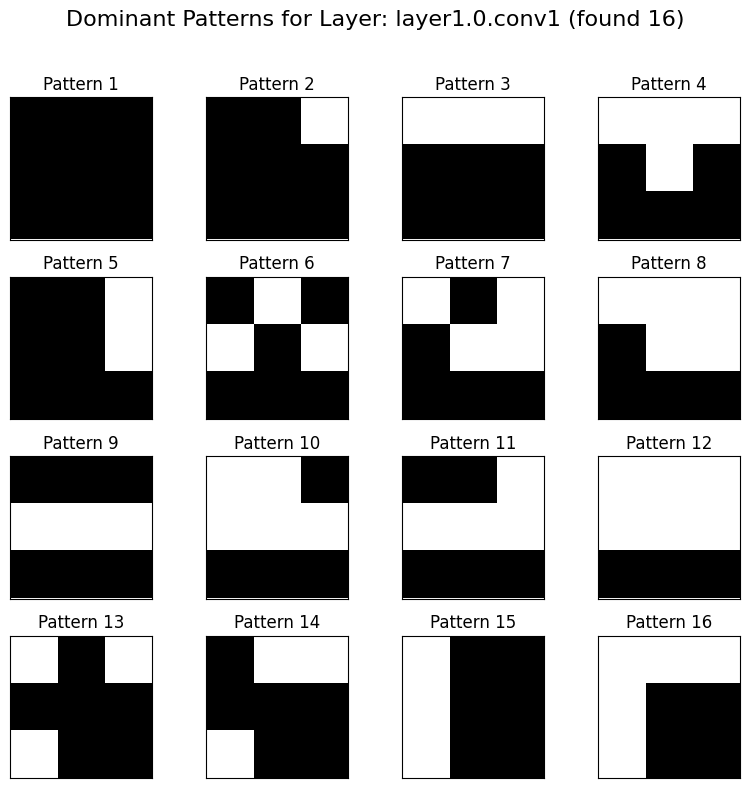

In [15]:
visualize_conv_patterns(model_paca, 'layer1.0.conv1')

In [16]:
def train_resnet(model, trainloader, device, loss_func, epoch, optimizer, scheduler, *args, **kwargs):
    first_batch = True
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.)) # 8 bits input quantization
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        losses = get_model_losses(model, torch.tensor(0.).to(device))
        loss += losses
        loss.backward()

        if first_batch:
            print("\n ---- Checking Loss values ----")
            print("Loss:", loss_func(outputs, labels).item())
            print("Model Losses:", losses.item())
            print("--------------------------------------------------")

            for name, module in model.named_modules():
                if "conv1" in name and hasattr(module, "pruning_layer"):
                    pruning_layer = module.pruning_layer
                    if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                        metric_fn = pruning_layer.metric_fn
                        num_patterns = 0
                        if metric_fn.dominant_patterns is not None:
                            num_patterns = metric_fn.dominant_patterns.shape[0]

                        total_dist = metric_fn(module.weight).item()
                        num_kernels = module.weight.shape[0]
                        avg_dist = total_dist / num_kernels if num_kernels > 0 else 0

                        print(f"--- PACA Stats for {name} at Epoch {epoch} ---")
                        print(f"Num Patterns: {num_patterns}, Avg Pattern Dist: {avg_dist:.4f}")
                        print("--------------------------------------------------\n")
                        break
            first_batch = False

        optimizer.step()
        epoch += 1
        if scheduler is not None:
            scheduler.step()

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    correct = 0
    total = 0
    num_paca_patterns = 0
    avg_paca_dist = 0.0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        for name, module in model.named_modules():
            if "conv1" in name and hasattr(module, "pruning_layer"):
                pruning_layer = module.pruning_layer
                if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                    metric_fn = pruning_layer.metric_fn
                    if metric_fn.dominant_patterns is not None:
                        num_paca_patterns = metric_fn.dominant_patterns.shape[0]

                    total_dist = metric_fn(module.weight).item()
                    num_kernels = module.weight.shape[0]
                    avg_paca_dist = total_dist / num_kernels if num_kernels > 0 else 0
                    break

        ratio = get_layer_keep_ratio(model)
        print(f'Accuracy: {100 * correct / total:.2f}%, '
              f'Remaining Weights: {ratio * 100:.2f}%, '
              f'Num Patterns: {num_paca_patterns}, '
              f'Avg Pattern Dist: {avg_paca_dist:.4f}')

BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

## Create loss function, scheduler and optimizer

In [17]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

## Train model
Training time. We use the train_compressed_model function from pquant to train. We need to provide some parameters such as training and validation functions, their input parameters, the model and the config file. The function automatically adds pruning layers and replaces activations with a quantized variant, trains the model, and removes the pruning layers after training is done

In [18]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model_paca = iterative_train(model = model_paca, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )


 ---- Checking Loss values ----
Loss: 0.709356427192688
Model Losses: 2.29872099133388e-09
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 0 ---
Num Patterns: 16, Avg Pattern Dist: 0.0003
--------------------------------------------------

Accuracy: 10.00%, Remaining Weights: 100.00%, Num Patterns: 1, Avg Pattern Dist: nan

 ---- Checking Loss values ----
Loss: nan
Model Losses: nan
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 197 ---
Num Patterns: 1, Avg Pattern Dist: nan
--------------------------------------------------

Accuracy: 10.00%, Remaining Weights: 100.00%, Num Patterns: 1, Avg Pattern Dist: nan

 ---- Checking Loss values ----
Loss: nan
Model Losses: nan
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 394 ---
Num Patterns: 1, Avg Pattern Dist: nan
--------------------------------------------------

Accuracy: 10.00%, Remaining Weights: 100.00%, Num Patterns: 1,

KeyboardInterrupt: 

(3, 3)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


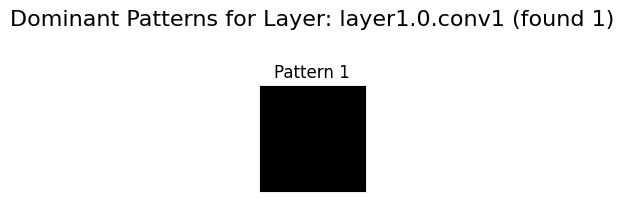

In [ ]:
visualize_conv_patterns(model_paca, 'layer1.0.conv1')